<a href="https://colab.research.google.com/github/zeynepervayalindag/smart_elevator_control_environment_reinforcement_learning/blob/main/agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**AKILLI ASANSÖR KONTROLÜ**

**Senaryo:** *Bir yapıda birden fazla asansör var. Yolcular yapının farklı katlarından asansör çağrıyor.*

**Amaç fonksiyonu:** Bekleme süresini azaltmak, enerji tüketimini düşürmek ve verimli yolcu taşımak.

**Durum(State):** *Katlarda bekleyen yolcuların sayısı, her asansörün mevcut katı, yönü(yukarı/ aşağı),* yükü

**Eylem(Action):** *Her asansör için bir sonraki hareket kararı*(yukarı, aşağı, bekle, kapıyı aç)

**Ödül(Reward):** *Yolcu taşıma +5, yolcunun zamanında asansöre binmesi +3, boşta gezinme -1, aynı katta iki asansör bekleme -5*

*İpucu: Asansör ajanları ayrı öğrenebilir (çok ajanlı öğrenme) veya merkezi bir ajan tüm sistemi kontrol edebilir.*

*Karışık sayıda katlarda bekleyen yolcu sayısı ve asansöre binen yolcu sayısı*

*Zamanı(t) minimize etmek*

*En az yol(x)*
Kilogram sayısı ceza
Eşit büyüklükte yük



In [1]:
import numpy as np
import random

In [2]:
class Passenger(object):
    '''
    Yapının katlarında bekleyen yolcu sayısı rastgele belirlenmektedir.
    Yolcuların hedef katı da rastgele belirlenmektedir.
    '''
    def __init__(self,now_floor : int,max_floor : int):
        self.now_floor = now_floor
        # Yolcu bulunduğu kat hariç rastgele hedef kat seçer.
        self.dest = random.choice(list(range(now_floor)) + list(range(now_floor+1,max_floor)))

    def get_dest(self) -> int:
        return self.dest

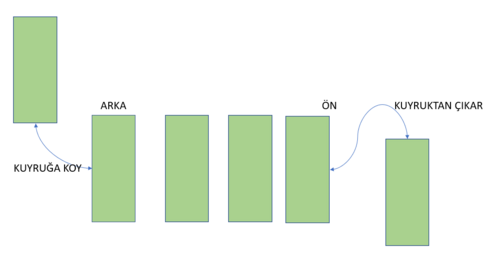

FIFO algoritmasının temsili resmi

In [3]:
class Elevator(object):
    '''
    Asansöre binen yolcuyu hedef kata taşırsa olumlu ödül kazanılır.
    '''
    def __init__(self, idx : int, max_passengers : int, max_floor : int):
        '''
        idx(int): Sınıflandırılacak asansör adı
        max_passengers(int): Taşınabilecek yolcu sayısı
        max_floor(int): Yapıdaki maksimum kat sayısı
        curr_floor(int): Asansörün mevcut katı
        curr_passengers_in_elv(list(Passanger)): Bu asansörle taşınan yolcular
        arrived_passengers_num(int): Ödülü hesaplamak için gelen yolcu sayısı
        '''
        self.idx = idx
        self.max_floor = max_floor
        self.max_passengers = max_passengers
        self.curr_floor = 0
        self.curr_passengers_in_elv = []
        self.arrived_passengers_num = 0
    # Asansör için yukarı hareket kararı
    def move_up(self):
        if self.curr_floor < self.max_floor-1:
            self.curr_floor += 1
    # Asansör için aşağı hareket kararı
    def move_down(self):
        if self.curr_floor > 0:
            self.curr_floor -= 1
    # Asansörle taşınan yolcu sayısı 0 ise asansörün mevcut katı 0 olur.
    def empty(self):
        self.curr_passengers_in_elv = []
        self.curr_floor = 0

    def load_passengers(self, passengers_in_floor : int) -> list:
        '''
        res(list(Passenger)) : Asansörün maksimum kapasitesi nedeniyle asansöre binemeyen yolcular
        '''
        if len(passengers_in_floor) > (self.max_passengers - len(self.curr_passengers_in_elv)):
            #FIFO(First in first out)(İlk sıraya giren asansöre ilk binen yolcudur.)
            res = passengers_in_floor[self.max_passengers - len(self.curr_passengers_in_elv):]
            for p in passengers_in_floor[:self.max_passengers - len(self.curr_passengers_in_elv)]:
                self.curr_passengers_in_elv.append(p)
        else:
            for p in passengers_in_floor:
                self.curr_passengers_in_elv.append(p)
            res = []
        # Geriye asansöre binemeyen yolcular döndürülür.
        return res
    def get_passengers_info(self) -> list :
        return [p.get_dest() for p in self.curr_passengers_in_elv]
    def unload_passengers(self, passengers_in_floor : list) -> int:
        '''
        arrive_passengers(list(Passenger)) : Bu katta asansörden indirilecek yolcular
        '''
        arrived_passengers = []
        num_in_floor = len(passengers_in_floor)
        self.arrived_passengers_num = 0
        for i in range(len(self.curr_passengers_in_elv)):
            if self.curr_passengers_in_elv[i].dest == self.curr_floor:
                arrived_passengers.append(i)
        if len(arrived_passengers) !=0:
            self.arrived_passengers_num = len(arrived_passengers)
            arrived_passengers.reverse() #IndexError ya da  yanlış yolcuyu kaldırmayı engellemek için
            for i in arrived_passengers:
                self.curr_passengers_in_elv.pop(i)
        # İnen yolcu sayısı ödül için tutulur
        '''
        for p in ((self.curr_passengers_in_elv)):
            if p.dest == self.curr_floor:
                self.curr_passengers_in_elv.remove(p)
                self.arrived_passengers_num += 1
        '''
        return self.arrived_passengers_num

In [4]:
class Building(object):
    def __init__(self, total_elevator_num : int, max_floor : int, max_passengers_in_floor : int,max_passengers_in_elevator : int, elevator_capacity : int = 10):
        '''
        remain_passengers_num(int): Yapıda kalan yolcu sayısı
        total_elevator_num(int): Yapıdaki toplam asansör sayısı
        max_passengers_in_floor(int): Katta bekleyen maksimum yolcu sayısı
        max_passengers_in_elevator(int): Asansöre binen maksimum yolcu sayısı
        max_floor(int): Yapıdaki maksimum kat sayısı
        floors_information(list(Passenger)): Yapının her kattaki yolcu bilgileri
        elevators(list(Elevator)): Asansör listesi
        '''
        self.remain_passengers_num = 0
        self.cumulated_reward = 0
        self.total_elevator_num = total_elevator_num
        self.max_passengers_in_floor = max_passengers_in_floor
        self.max_passengers_in_elevator = max_passengers_in_elevator
        self.elevators = []
        for idx in range(total_elevator_num):
            self.elevators.append(Elevator(idx, elevator_capacity, max_floor))
        self.max_floor = max_floor
        self.floors_information = []
        for idx in range(max_floor):
            self.floors_information.append([])

    def get_arrived_passengers(self) -> int :
        arrived_passengers=0
        for e in self.elevators:
            arrived_passengers += e.arrived_passengers_num
            e.arrived_passengers_num = 0
        return arrived_passengers

    def get_state(self) -> tuple:
        floor_passengers = [[[floor,passenger.get_dest()] for passenger in passengers] for floor, passengers in enumerate(self.floors_information)]
        floor_passengers = [x for x in floor_passengers if x != []]
        floor_passengers = [y for x in floor_passengers for y in x]
        if len(floor_passengers) == 0 :
            floor_passengers.append([-1,-1])
        elv_passengers = [e.get_passengers_info() for e in self.elevators]
        elv_passengers = [x for x in elv_passengers if x != []]
        if len(elv_passengers) == 0 :
            elv_passengers.append([-1])
        elevators_floors = [e.curr_floor for e in self.elevators]
        return floor_passengers,elv_passengers,elevators_floors

    def empty_building(self):
        self.floors_information = []

        for idx in range(self.max_floor):
            self.floors_information.append([])
        for e in self.elevators:
            e.empty()
        self.remain_passengers_num = 0
    def get_remain_passengers_in_building(self):
        return sum([len(x) for x in self.floors_information])
    def get_remain_passengers_in_elv(self,elv):
        return len(elv.curr_passengers_in_elv)
    def get_remain_all_passengers(self):
        return sum([self.get_remain_passengers_in_elv(x) for x in self.elevators]) +  self.get_remain_passengers_in_building()
    def generate_passengers(self, prob : float, passenger_max_num : int = 6):
        '''
        Rastgele sayıda yolcu
        '''
        for floor_num in range(0, self.max_floor):
            if np.random.random() < prob and len(self.floors_information[floor_num]) < self.max_passengers_in_floor:
                passenger_num = np.random.randint(1,passenger_max_num)
                passenger_num = min(self.max_passengers_in_floor, len(self.floors_information[floor_num]) + passenger_num)
                additional_passengers = []
                for p in range(passenger_num):
                    additional_passengers.append(Passenger(now_floor=floor_num, max_floor=self.max_floor))
                self.floors_information[floor_num] += additional_passengers
                self.remain_passengers_num += passenger_num

    def perform_action(self, action: list):
      reward = 0

      # Aksiyonlar
      for idx, e in enumerate(self.elevators):

          if action[idx] == 0:  # aşağı
              if e.curr_floor == 0:
                  reward -= 1
              else:
                  e.move_down()

          elif action[idx] == 1:  # yukarı
              if e.curr_floor == e.max_floor - 1:
                  reward -= 1
              else:
                  e.move_up()

          elif action[idx] == 2:  # Yolcunun zamanında asansöre binmesi +3
              if len(self.floors_information[e.curr_floor]) > 0:
                  before = len(e.curr_passengers_in_elv)
                  self.floors_information[e.curr_floor] = e.load_passengers(
                      self.floors_information[e.curr_floor]
                  )
                  after = len(e.curr_passengers_in_elv)
                  if after > before:
                      reward += 3
              else:
                  reward -= 1

          elif action[idx] == 3:  # yolcu indirmek Yolcu taşıma +5
              arrived = e.unload_passengers(self.floors_information[e.curr_floor])
              if arrived > 0:
                  reward += arrived * 5
              else:
                  reward -= 1

      # Aynı katta birden fazla asansör bekleme -5
      floor_count = {}
      for e in self.elevators:
          floor_count[e.curr_floor] = floor_count.get(e.curr_floor, 0) + 1

      for count in floor_count.values():
          if count > 1:
              reward -= 5 * (count - 1)

      # Boşta gezinme -1
      if self.get_remain_all_passengers() > 0:
          reward -= 1

      return reward

    def print_building(self, step : int):
        for idx in reversed(list(range(1,self.max_floor))):
            print("=======================================================")
            print("= Floor #%02d ="%idx, end=' ')
            for e in self.elevators:
                if e.curr_floor == idx:
                    print("  Lift #%d"%e.idx, end=' ')
                else:
                    print("         ", end=' ')
            print(" ")
            print("=  Waiting  =", end=' ')
            for e in self.elevators:
                if e.curr_floor == idx:
                    print("    %02d   "%len(e.curr_passengers_in_elv), end=' ')
                else:
                    print("          ", end=' ')
            print(" ")
            print("=    %03d    ="%len(self.floors_information[idx]))
        print("=======================================================")
        print("= Floor #00 =", end=' ')
        for e in self.elevators:
            if e.curr_floor == 0:
                print("  Lift #%d"%e.idx, end=' ')
            else:
                print("         ", end=' ')
        print(" ")
        print("=  Arrived  =", end=' ')
        for e in self.elevators:
            if e.curr_floor == 0:
                print("    %02d   "%len(e.curr_passengers_in_elv), end=' ')
            else:
                print("          ", end=' ')
        print(" ")
        print("=    %03d    ="%len(self.floors_information[0]))
        print("=======================================================")
        print("")
        print("People to move: %d "%(self.remain_passengers_num - len(self.floors_information[0])))
        print("Total # of people: %d"%self.remain_passengers_num)
        print("Step: %d"%step)
        print('state : ',self.get_state())
        #print('now reward : ',self.get_reward())

In [5]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00


**Beş katlı bir binada tek asansörlü simülasyon ortamının model eğitimi**

In [7]:
import argparse
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

#Hyperparameters
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20
learning_rate = 0.001
MAX_PASSENGERS_LENGTH = 40
MAX_ELV_LENGTH = 10

add_people_at_step = 25
add_people_prob = 0.8

print_interval = 20
global_step = 0

class SequenceEncoder(nn.Module):
    def __init__(self,input_dim,seq_len,encoding_dim = 128,head_num = 16, normalization=True):
        super(SequenceEncoder,self).__init__()
        self.normalization = normalization
        self.linear_1 = nn.Linear(input_dim,encoding_dim)
        self.attention = nn.MultiheadAttention(encoding_dim, head_num)

        self.conv_1 = nn.Conv1d(encoding_dim,encoding_dim,1)
        self.conv_2 = nn.Conv1d(encoding_dim,encoding_dim*1,1)
        self.norm = nn.BatchNorm1d(encoding_dim*1)
        ##self.lstm = nn.LSTM(input_size = encoding_dim,hidden_size = encoding_dim,num_layers = 1,bidirectional=True,batch_first = True)
        ##self.linear_2 = nn.Linear(encoding_dim*2,encoding_dim)
        self.linear_2 = nn.Linear(seq_len,1)
    def forward(self,x):
        '''
        #(1,3,40)
        (batch_size, hidden_size, max_seq_len)
        '''
        x = x.permute(0,2,1) #(batch_size, max_seq_len, hidden_size)
        x = self.linear_1(x) #(batch_size, max_seq_len, encoding_dim)
        x = x.permute(1,0,2)#(max_seq_len, batch_size, encoding_dim)
        x,_ = self.attention(x,x,x) #(max_seq_len, batch_size, encoding_dim)
        x = x.permute(1,2,0) #(batch_size, encoding_dim,max_seq_len)

        x_ = F.relu(self.conv_1(x)) #(batch_size, encoding_dim,max_seq_len)
        x_ = self.conv_2(x_) #(batch_size, encoding_dim,max_seq_len)

        x = x_ + x
        ####if self.normalization == True:
        ####    x = self.norm(x)
        #x(batch_size, encoding_dim,max_seq_len)
        ##x,_ = self.lstm(F.relu(x.transpose(2,1)))
        ##x = x[:,-1,:]
        ##x = self.linear_2(F.relu(x))
        x = self.linear_2(F.relu(x)).squeeze(-1)
        return x
class Agent(nn.Module):
    def __init__(self, action_dim):
        super(Agent,self).__init__()
        self.memory = []
        self.floor_encoder = SequenceEncoder(2,40)
        self.elv_encoder = SequenceEncoder(1,10)
        self.elv_place_encoder_1 = nn.Linear(1,32)
        self.elv_place_encoder_2 = nn.Linear(32,64)
        self.action_1 = nn.Linear(256+64,128)
        self.action_2 = nn.Linear(128,action_dim)
        self.value_1 = nn.Linear(256+64,128)
        self.value_2 = nn.Linear(128,1)

        self.optimizer = optim.Adam(self.parameters(),lr = learning_rate)

    def get_action(self,floor,elv,elv_place,softmax_dim = -1):
        #(batch_size, hidden_size, max_seq_len)
        floor = self.floor_encoder(floor)
        elv = self.elv_encoder(elv)
        elv_place = F.relu(self.elv_place_encoder_1(elv_place))
        elv_place = (self.elv_place_encoder_2(elv_place))
        x = torch.cat((floor,elv,elv_place),-1)
        #x = F.relu(x)
        action = F.relu(self.action_1(x))
        action = self.action_2(action)
        prob = F.softmax(action, dim = softmax_dim)
        return prob
    def get_value(self,floor,elv,elv_place):
        floor = self.floor_encoder(floor)
        elv = self.elv_encoder(elv)
        elv_place = F.relu(self.elv_place_encoder_1(elv_place))
        elv_place = (self.elv_place_encoder_2(elv_place))
        x = torch.cat((floor,elv,elv_place),-1)
        #x = F.relu(x)

        value = self.value_1(x)
        value = self.value_2(value)
        return value

    def put_data(self,data):
        self.memory.append(data)

    def make_batch(self):
        state_1_list,state_2_list,state_3_list, action_list, reward_list, next_state_1_list,next_state_2_list,next_state_3_list, prob_list, done_list = [],[],[],[],[],[],[],[],[],[]
        for data in self.memory:
            state_1,state_2,state_3,action,reward,next_state_1,next_state_2,next_state_3,prob,done = data
            state_1_list.append(state_1)
            state_2_list.append(state_2)
            state_3_list.append(state_3)
            action_list.append([action])
            reward_list.append([reward])
            prob_list.append([prob])
            next_state_1_list.append(next_state_1)
            next_state_2_list.append(next_state_2)
            next_state_3_list.append(next_state_3)
            done_mask = 0 if done else 1
            done_list.append([done_mask])
        self.memory = []

        s1,s2,s3,a,r,next_s1,next_s2,next_s3,done_mask,prob = (
            torch.tensor(state_1_list,dtype=torch.float).to(device),
            torch.tensor(state_2_list,dtype=torch.float).to(device),
            torch.tensor(state_3_list,dtype=torch.float).to(device),
            torch.tensor(action_list).to(device),torch.tensor(reward_list).to(device),
            torch.tensor(next_state_1_list,dtype=torch.float).to(device),
            torch.tensor(next_state_2_list,dtype=torch.float).to(device),
            torch.tensor(next_state_3_list,dtype=torch.float).to(device),
            torch.tensor(done_list,dtype = torch.float).to(device),
            torch.tensor(prob_list).to(device)
        )
        return s1.squeeze(1),s2.squeeze(1),s3.squeeze(1),a,r,next_s1.squeeze(1),next_s2.squeeze(1),next_s3.squeeze(1),done_mask,prob

    def train(self,epoch, summary):
        state_1,state_2,state_3,action,reward, next_state_1,next_state_2,next_state_3,done_mask,action_prob = self.make_batch()

        for i in range(K_epoch):
            td_error = reward + gamma * self.get_value(next_state_1,next_state_2,next_state_3) * done_mask
            delta = td_error - self.get_value(state_1,state_2,state_3)
            if torch.cuda.is_available():
                delta = delta.cpu().detach().numpy()
            else:
                delta = delta.detach().numpy()
            advantage_list = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_list.append([advantage])
            advantage_list.reverse()
            advantage = torch.tensor(advantage_list,dtype = torch.float).to(device)


            now_action = self.get_action(state_1,state_2,state_3,softmax_dim = -1)
            now_action = now_action.gather(1,action)

            ratio = torch.exp(torch.log(now_action) - torch.log(action_prob))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio , 1-eps_clip, 1 + eps_clip) * advantage
            loss_1 = - torch.min(surr1,surr2).mean()
            loss_2 = F.smooth_l1_loss(self.get_value(state_1,state_2,state_3),td_error.detach())
            loss = loss_1 + loss_2
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if i == 0 :
                summary.add_scalar('loss/loss_1', loss_1.item(), epoch)
                summary.add_scalar('loss/loss_2', loss_2.item(), epoch)


def is_finish(state):
    finish_check_1 = (state[0][0][0] == -1)
    finish_check_2 = (state[1][0][0] == -1)
    return (finish_check_1 and finish_check_2)
def main():
    parser = argparse.ArgumentParser('parameters')
    parser.add_argument('--test', type=bool, default=False, help="True if test, False if train (default: False)")
    parser.add_argument('--epochs', type=int, default=10000, help='number of epochs, (default: 100)')
    parser.add_argument('--lr_rate', type=float, default=0.0001, help='learning rate (default : 0.0001)')
    parser.add_argument('--lift_num', type=int, default=1, help='number of elevators ')
    parser.add_argument('--building_height', type=int, default=5, help='building height ')
    parser.add_argument('--max_people_in_floor', type=int, default=8, help='maximum people in one floor')
    parser.add_argument('--max_people_in_elevator', type=int, default=8, help='maximum people in one elevator')
    parser.add_argument("--load_file", type=str, default = 'no', help = 'load initial parameters')
    parser.add_argument("--save_interval", type=int, default = 500, help = 'save interval')
    parser.add_argument("--print_interval", type=int, default = 20, help = 'print interval')
    args, unknown = parser.parse_known_args()
    print('args.test : ',args.test)
    print('args.epochs : ', args.epochs)
    print('args.lr_rate : ',args.lr_rate)
    print('args.lift_num : ', args.lift_num)
    print('args.building_height :',args.building_height)
    print('args.max_people_in_floor : ',args.max_people_in_floor )
    print('args.max_people_in_elevator :', args.max_people_in_elevator)
    print('args.load_file : ',args.load_file)
    print('args.save_interval :',args.save_interval)
    print('args.print_interval :',args.print_interval)
    summary = SummaryWriter()
    building = Building(args.lift_num, args.building_height, args.max_people_in_floor,                        args.max_people_in_elevator)
    ave_steps = 0
    model = Agent(action_dim = 4)
    if torch.cuda.is_available():
        model.cuda()
    os.makedirs('./model_weights', exist_ok=True)
    for epoch in range(args.epochs):
        building.empty_building()
        while building.remain_passengers_num == 0 :
            building.generate_passengers(add_people_prob)
        floor_state,elv_state,elv_place_state = building.get_state()
        floor_state = torch.tensor(floor_state).transpose(1,0).unsqueeze(0).float()
        floor_state = torch.cat((floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - floor_state.shape[2]))),-1)/10.
        elv_state = torch.tensor(elv_state).unsqueeze(0).float()
        elv_state = torch.cat((elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - elv_state.shape[2]))),-1)/10.
        elv_place_state = torch.tensor(elv_place_state).unsqueeze(0).float()/10.
        done = False
        global_step = 0
        while not done:
            global_step += 1
            action_prob = model.get_action(floor_state.to(device),elv_state.to(device),elv_place_state.to(device))[0]
            m = Categorical(action_prob)
            action = m.sample().item()
            reward = building.perform_action([action])
            next_floor_state,next_elv_state,next_elv_place_state = building.get_state()
            done = is_finish((next_floor_state,next_elv_state))
            next_floor_state = torch.tensor(next_floor_state).transpose(1,0).unsqueeze(0).float()
            next_floor_state = torch.cat((next_floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - next_floor_state.shape[2]))),-1)/10.
            next_elv_state = torch.tensor(next_elv_state).unsqueeze(0).float()
            next_elv_state = torch.cat((next_elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - next_elv_state.shape[2]))),-1)/10.
            next_elv_place_state = torch.tensor(next_elv_place_state).unsqueeze(0).float()/10.
            model.put_data((floor_state.tolist(),elv_state.tolist(),elv_place_state.tolist(), action, reward/100.0, next_floor_state.tolist(),next_elv_state.tolist(), next_elv_place_state.tolist(), action_prob[action].item(), done))
            floor_state = next_floor_state
            elv_state = next_elv_state
            elv_place_state = next_elv_place_state
            if args.test:
                os.system("cls")
                building.print_building(global_step)
                print(action)
                print('now reward : ',reward)

                time.sleep(1.5)
            if done or (global_step > 300):
                done = True
                break
        model.train(epoch, summary) # Pass summary object
        summary.add_scalar('reward', global_step, epoch)
        ave_steps += global_step

        if epoch%args.print_interval==0 and epoch!=0:
            print("# of episode :{}, avg episodes : {:.1f}".format(epoch, ave_steps/args.print_interval))
            ave_steps = 0
        if (epoch % args.save_interval == 0 )& (epoch != 0):
            torch.save(model.state_dict(), './model_weights/model_'+str(epoch))
if __name__ == '__main__':
    main()

args.test :  False
args.epochs :  10000
args.lr_rate :  0.0001
args.lift_num :  1
args.building_height : 5
args.max_people_in_floor :  8
args.max_people_in_elevator : 8
args.load_file :  no
args.save_interval : 500
args.print_interval : 20
# of episode :20, avg episodes : 179.4
# of episode :40, avg episodes : 200.3
# of episode :60, avg episodes : 157.3
# of episode :80, avg episodes : 155.2
# of episode :100, avg episodes : 173.9
# of episode :120, avg episodes : 159.9
# of episode :140, avg episodes : 109.7
# of episode :160, avg episodes : 90.5
# of episode :180, avg episodes : 124.1
# of episode :200, avg episodes : 121.0
# of episode :220, avg episodes : 91.2
# of episode :240, avg episodes : 177.9
# of episode :260, avg episodes : 259.1
# of episode :280, avg episodes : 108.5
# of episode :300, avg episodes : 92.2
# of episode :320, avg episodes : 92.2
# of episode :340, avg episodes : 79.5
# of episode :360, avg episodes : 150.4
# of episode :380, avg episodes : 212.2
# of epis

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter
import argparse
import numpy as np
import os
import time

gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

add_people_at_step = 25
add_people_prob = 0.8
print_interval = 20
global_step = 0
MAX_PASSENGERS_LENGTH = 40
MAX_ELV_LENGTH = 10

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

# The following classes (SequenceEncoder and Agent) and functions (is_finish) are expected to be defined in previously executed cells.
# Since they are not explicitly in this selected cell, I'm assuming their definitions from the notebook state.
# If they were part of this cell, I would include them in the modification.

def main():
    parser = argparse.ArgumentParser('parameters')
    parser.add_argument('--test', type=bool, default=False, help="True if test, False if train (default: False)")
    parser.add_argument('--epochs', type=int, default=10000, help='number of epochs, (default: 100)')
    parser.add_argument('--lr_rate', type=float, default=0.0001, help='learning rate (default : 0.0001)')
    parser.add_argument('--lift_num', type=int, default=1, help='number of elevators ')
    parser.add_argument('--building_height', type=int, default=5, help='building height ')
    parser.add_argument('--max_people_in_floor', type=int, default=8, help='maximum people in one floor')
    parser.add_argument('--max_people_in_elevator', type=int, default=8, help='maximum people in one elevator')
    parser.add_argument("--load_file", type=str, default = 'no', help = 'load initial parameters')
    parser.add_argument("--save_interval", type=int, default = 500, help = 'save interval')
    parser.add_argument("--print_interval", type=int, default = 20, help = 'print interval')
    args, unknown = parser.parse_known_args() # Changed from parse_args() to parse_known_args() to handle Colab's default arguments
    print('args.test : ',args.test)
    print('args.epochs : ', args.epochs)
    print('args.lr_rate : ',args.lr_rate)
    print('args.lift_num : ', args.lift_num)
    print('args.building_height :',args.building_height)
    print('args.max_people_in_floor : ',args.max_people_in_floor )
    print('args.max_people_in_elevator :', args.max_people_in_elevator)
    print('args.load_file : ',args.load_file)
    print('args.save_interval :',args.save_interval)
    print('args.print_interval :',args.print_interval)

    building = Building(args.lift_num, args.building_height, args.max_people_in_floor,
                        args.max_people_in_elevator)
    ave_steps = 0
    model = Agent(4)

    summary = SummaryWriter()
    if torch.cuda.is_available():
        model.cuda()
    # Create the directory for saving model weights if it doesn't exist
    os.makedirs('./model_weights', exist_ok=True)
    for epoch in range(args.epochs):
        building.empty_building()
        while building.remain_passengers_num == 0 :
            building.generate_passengers(add_people_prob)
        floor_state,elv_state,elv_place_state = building.get_state()
        floor_state = torch.tensor(floor_state).transpose(1,0).unsqueeze(0).float()
        floor_state = torch.cat((floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - floor_state.shape[2]))),-1)/10.
        elv_state = torch.tensor(elv_state).unsqueeze(0).float()
        elv_state = torch.cat((elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - elv_state.shape[2]))),-1)/10.
        elv_place_state = torch.tensor(elv_place_state).unsqueeze(0).float()/10.
        done = False
        global_step = 0
        while not done:
            global_step += 1
            action_prob = model.get_action(floor_state.to(device),elv_state.to(device),elv_place_state.to(device))[0]
            m = Categorical(action_prob)
            action = m.sample().item()
            reward = building.perform_action([action])
            next_floor_state,next_elv_state,next_elv_place_state = building.get_state()
            done = is_finish((next_floor_state,next_elv_state))
            next_floor_state = torch.tensor(next_floor_state).transpose(1,0).unsqueeze(0).float()
            next_floor_state = torch.cat((next_floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - next_floor_state.shape[2]))),-1)/10.
            next_elv_state = torch.tensor(next_elv_state).unsqueeze(0).float()
            next_elv_state = torch.cat((next_elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - next_elv_state.shape[2]))),-1)/10.
            next_elv_place_state = torch.tensor(next_elv_place_state).unsqueeze(0).float()/10.
            model.put_data((floor_state.tolist(),elv_state.tolist(),elv_place_state.tolist(), action, reward/100.0, next_floor_state.tolist(),next_elv_state.tolist(), next_elv_place_state.tolist(), action_prob[action].item(), done))
            floor_state = next_floor_state
            elv_state = next_elv_state
            elv_place_state = next_elv_place_state
            if args.test:
                os.system("cls")
                building.print_building(global_step)
                print(action)
                print('now reward : ',reward)

                time.sleep(1.5)
            if done or (global_step > 300):
                done = True
                break
        model.train(epoch, summary)
        summary.add_scalar('reward', global_step, epoch)
        ave_steps += global_step

        if epoch%args.print_interval==0 and epoch!=0:
            print("# of episode :{}, avg episodes : {:.1f}".format(epoch, ave_steps/args.print_interval))
            ave_steps = 0
        if (epoch % args.save_interval == 0 )& (epoch != 0):
            torch.save(model.state_dict(), './model_weights/model_'+str(epoch))
if __name__ == '__main__':
    main()

args.test :  False
args.epochs :  10000
args.lr_rate :  0.0001
args.lift_num :  1
args.building_height : 5
args.max_people_in_floor :  8
args.max_people_in_elevator : 8
args.load_file :  no
args.save_interval : 500
args.print_interval : 20
# of episode :20, avg episodes : 148.7
# of episode :40, avg episodes : 135.2
# of episode :60, avg episodes : 132.9
# of episode :80, avg episodes : 191.2
# of episode :100, avg episodes : 191.1
# of episode :120, avg episodes : 140.9
# of episode :140, avg episodes : 164.6
# of episode :160, avg episodes : 151.8
# of episode :180, avg episodes : 129.5
# of episode :200, avg episodes : 170.7
# of episode :220, avg episodes : 212.1
# of episode :240, avg episodes : 197.2
# of episode :260, avg episodes : 190.1
# of episode :280, avg episodes : 208.1
# of episode :300, avg episodes : 201.2
# of episode :320, avg episodes : 185.3
# of episode :340, avg episodes : 168.5
# of episode :360, avg episodes : 195.6
# of episode :380, avg episodes : 216.4
# of

**Beş katlı bir binada tek asansörlü simülasyon ortamının test edilmesi**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter
import argparse
import numpy as np
import os
import time

gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

add_people_at_step = 25
add_people_prob = 0.8
print_interval = 20
global_step = 0
MAX_PASSENGERS_LENGTH = 40
MAX_ELV_LENGTH = 10

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

# The following classes (SequenceEncoder and Agent) and functions (is_finish) are expected to be defined in previously executed cells.
# Since they are not explicitly in this selected cell, I'm assuming their definitions from the notebook state.
# If they were part of this cell, I would include them in the modification.

def main():
    parser = argparse.ArgumentParser('parameters')
    parser.add_argument('--test', type=bool, default=True, help="True if test, False if train (default: False)")
    parser.add_argument('--epochs', type=int, default=10000, help='number of epochs, (default: 100)')
    parser.add_argument('--lr_rate', type=float, default=0.0001, help='learning rate (default : 0.0001)')
    parser.add_argument('--lift_num', type=int, default=1, help='number of elevators ')
    parser.add_argument('--building_height', type=int, default=5, help='building height ')
    parser.add_argument('--max_people_in_floor', type=int, default=8, help='maximum people in one floor')
    parser.add_argument('--max_people_in_elevator', type=int, default=8, help='maximum people in one elevator')
    parser.add_argument("--load_file", type=str, default = 'no', help = 'load initial parameters')
    parser.add_argument("--save_interval", type=int, default = 500, help = 'save interval')
    parser.add_argument("--print_interval", type=int, default = 20, help = 'print interval')
    args, unknown = parser.parse_known_args() # Changed from parse_args() to parse_known_args() to handle Colab's default arguments
    print('args.test : ',args.test)
    print('args.epochs : ', args.epochs)
    print('args.lr_rate : ',args.lr_rate)
    print('args.lift_num : ', args.lift_num)
    print('args.building_height :',args.building_height)
    print('args.max_people_in_floor : ',args.max_people_in_floor )
    print('args.max_people_in_elevator :', args.max_people_in_elevator)
    print('args.load_file : ',args.load_file)
    print('args.save_interval :',args.save_interval)
    print('args.print_interval :',args.print_interval)

    building = Building(args.lift_num, args.building_height, args.max_people_in_floor,
                        args.max_people_in_elevator)
    ave_steps = 0
    model = Agent(4)

    summary = SummaryWriter()
    if torch.cuda.is_available():
        model.cuda()
    # Create the directory for saving model weights if it doesn't exist
    os.makedirs('./model_weights', exist_ok=True)
    for epoch in range(args.epochs):
        building.empty_building()
        while building.remain_passengers_num == 0 :
            building.generate_passengers(add_people_prob)
        floor_state,elv_state,elv_place_state = building.get_state()
        floor_state = torch.tensor(floor_state).transpose(1,0).unsqueeze(0).float()
        floor_state = torch.cat((floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - floor_state.shape[2]))),-1)/10.
        elv_state = torch.tensor(elv_state).unsqueeze(0).float()
        elv_state = torch.cat((elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - elv_state.shape[2]))),-1)/10.
        elv_place_state = torch.tensor(elv_place_state).unsqueeze(0).float()/10.
        done = False
        global_step = 0
        while not done:
            global_step += 1
            action_prob = model.get_action(floor_state.to(device),elv_state.to(device),elv_place_state.to(device))[0]
            m = Categorical(action_prob)
            action = m.sample().item()
            reward = building.perform_action([action])
            next_floor_state,next_elv_state,next_elv_place_state = building.get_state()

            # Corrected is_finish function for robustness
            done = (len(next_floor_state) == 1 and next_floor_state[0] == [-1, -1]) and \
                   (len(next_elv_state) == 1 and next_elv_state[0] == [-1])

            next_floor_state = torch.tensor(next_floor_state).transpose(1,0).unsqueeze(0).float()
            next_floor_state = torch.cat((next_floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - next_floor_state.shape[2]))),-1)/10.
            next_elv_state = torch.tensor(next_elv_state).unsqueeze(0).float()
            next_elv_state = torch.cat((next_elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - next_elv_state.shape[2]))),-1)/10.
            next_elv_place_state = torch.tensor(next_elv_place_state).unsqueeze(0).float()/10.
            model.put_data((floor_state.tolist(),elv_state.tolist(),elv_place_state.tolist(), action, reward/100.0, next_floor_state.tolist(),next_elv_state.tolist(), next_elv_place_state.tolist(), action_prob[action].item(), done))
            floor_state = next_floor_state
            elv_state = next_elv_state
            elv_place_state = next_elv_place_state
            if args.test:
                os.system("cls")
                building.print_building(global_step)
                print(action)
                print('now reward : ',reward)

                time.sleep(1.5)
            if done or (global_step > 300):
                done = True
                break
        model.train(epoch, summary)
        summary.add_scalar('reward', global_step, epoch)
        ave_steps += global_step

        if epoch%args.print_interval==0 and epoch!=0:
            print("# of episode :{}, avg episodes : {:.1f}".format(epoch, ave_steps/args.print_interval))
            ave_steps = 0
        if (epoch % args.save_interval == 0 )& (epoch != 0):
            torch.save(model.state_dict(), './model_weights/model_'+str(epoch))
if __name__ == '__main__':
    main()

Görüntülenen çıkış son 5000 satıra kısaltıldı.
= Floor #01 =            
=  Waiting  =             
=    000    =
= Floor #00 =            
=  Arrived  =             
=    004    =

People to move: 9 
Total # of people: 13
Step: 122
state :  ([[0, 4], [0, 4], [0, 4], [0, 4]], [[-1]], [2])
1
now reward :  -1
= Floor #04 =            
=  Waiting  =             
=    000    =
= Floor #03 =   Lift #0  
=  Waiting  =     00     
=    000    =
= Floor #02 =            
=  Waiting  =             
=    000    =
= Floor #01 =            
=  Waiting  =             
=    000    =
= Floor #00 =            
=  Arrived  =             
=    004    =

People to move: 9 
Total # of people: 13
Step: 123
state :  ([[0, 4], [0, 4], [0, 4], [0, 4]], [[-1]], [3])
1
now reward :  -1
= Floor #04 =   Lift #0  
=  Waiting  =     00     
=    000    =
= Floor #03 =            
=  Waiting  =             
=    000    =
= Floor #02 =            
=  Waiting  =             
=    000    =
= Floor #01 =            
=  

**Beş katlı bir binada iki asansörlü simülasyon ortamının model eğitimi**

In [17]:
import argparse
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

#Hyperparameters
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20
learning_rate = 0.001
MAX_PASSENGERS_LENGTH = 40
MAX_ELV_LENGTH = 10

add_people_at_step = 25
add_people_prob = 0.8

print_interval = 20
global_step = 0
def decode_action(action, lift_num):
    actions = []
    for _ in range(lift_num):
        actions.append(action % 4)
        action //= 4
    return actions

class SequenceEncoder(nn.Module):
    def __init__(self,input_dim,seq_len,encoding_dim = 128,head_num = 16, normalization=True):
        super(SequenceEncoder,self).__init__()
        self.normalization = normalization
        self.linear_1 = nn.Linear(input_dim,encoding_dim)
        self.attention = nn.MultiheadAttention(encoding_dim, head_num)

        self.conv_1 = nn.Conv1d(encoding_dim,encoding_dim,1)
        self.conv_2 = nn.Conv1d(encoding_dim,encoding_dim*1,1)
        self.norm = nn.BatchNorm1d(encoding_dim*1)
        ##self.lstm = nn.LSTM(input_size = encoding_dim,hidden_size = encoding_dim,num_layers = 1,bidirectional=True,batch_first = True)
        ##self.linear_2 = nn.Linear(encoding_dim*2,encoding_dim)
        self.linear_2 = nn.Linear(seq_len,1)
    def forward(self,x):
        '''
        #(1,3,40)
        (batch_size, hidden_size, max_seq_len)
        '''
        x = x.permute(0,2,1) #(batch_size, max_seq_len, hidden_size)
        x = self.linear_1(x) #(batch_size, max_seq_len, encoding_dim)
        x = x.permute(1,0,2)#(max_seq_len, batch_size, encoding_dim)
        x,_ = self.attention(x,x,x) #(max_seq_len, batch_size, encoding_dim)
        x = x.permute(1,2,0) #(batch_size, encoding_dim,max_seq_len)

        x_ = F.relu(self.conv_1(x)) #(batch_size, encoding_dim,max_seq_len)
        x_ = self.conv_2(x_) #(batch_size, encoding_dim,max_seq_len)

        x = x_ + x
        ####if self.normalization == True:
        ####    x = self.norm(x)
        #x(batch_size, encoding_dim,max_seq_len)
        ##x,_ = self.lstm(F.relu(x.transpose(2,1)))
        ##x = x[:,-1,:]
        ##x = self.linear_2(F.relu(x))
        x = self.linear_2(F.relu(x)).squeeze(-1)
        return x
class Agent(nn.Module):
    def __init__(self, action_dim, lift_num):
            super().__init__()
            self.memory = []

            self.floor_encoder = SequenceEncoder(2,40)
            self.elv_encoder = SequenceEncoder(1,10)

            self.elv_place_encoder_1 = nn.Linear(lift_num, 32)
            self.elv_place_encoder_2 = nn.Linear(32, 64)

            self.action_1 = nn.Linear(256+64,128)
            self.action_2 = nn.Linear(128, action_dim)

            self.value_1 = nn.Linear(256+64,128)
            self.value_2 = nn.Linear(128,1)

            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)



    def get_action(self,floor,elv,elv_place,softmax_dim = -1):
        #(batch_size, hidden_size, max_seq_len)
        floor = self.floor_encoder(floor)
        elv = self.elv_encoder(elv)
        elv_place = F.relu(self.elv_place_encoder_1(elv_place))
        elv_place = (self.elv_place_encoder_2(elv_place))
        x = torch.cat((floor,elv,elv_place),-1)
        #x = F.relu(x)
        action = F.relu(self.action_1(x))
        action = self.action_2(action)
        prob = F.softmax(action, dim = softmax_dim)
        return prob
    def get_value(self,floor,elv,elv_place):
        floor = self.floor_encoder(floor)
        elv = self.elv_encoder(elv)
        elv_place = F.relu(self.elv_place_encoder_1(elv_place))
        elv_place = (self.elv_place_encoder_2(elv_place))
        x = torch.cat((floor,elv,elv_place),-1)
        #x = F.relu(x)

        value = self.value_1(x)
        value = self.value_2(value)
        return value

    def put_data(self,data):
        self.memory.append(data)

    def make_batch(self):
        state_1_list,state_2_list,state_3_list, action_list, reward_list, next_state_1_list,next_state_2_list,next_state_3_list, prob_list, done_list = [],[],[],[],[],[],[],[],[],[]
        for data in self.memory:
            state_1,state_2,state_3,action,reward,next_state_1,next_state_2,next_state_3,prob,done = data
            state_1_list.append(state_1)
            state_2_list.append(state_2)
            state_3_list.append(state_3)
            action_list.append([action])
            reward_list.append([reward])
            prob_list.append([prob])
            next_state_1_list.append(next_state_1)
            next_state_2_list.append(next_state_2)
            next_state_3_list.append(next_state_3)
            done_mask = 0 if done else 1
            done_list.append([done_mask])
        self.memory = []

        s1,s2,s3,a,r,next_s1,next_s2,next_s3,done_mask,prob = (
            torch.tensor(state_1_list,dtype=torch.float).to(device),
            torch.tensor(state_2_list,dtype=torch.float).to(device),
            torch.tensor(state_3_list,dtype=torch.float).to(device),
            torch.tensor(action_list).to(device),torch.tensor(reward_list).to(device),
            torch.tensor(next_state_1_list,dtype=torch.float).to(device),
            torch.tensor(next_state_2_list,dtype=torch.float).to(device),
            torch.tensor(next_state_3_list,dtype=torch.float).to(device),
            torch.tensor(done_list,dtype = torch.float).to(device),
            torch.tensor(prob_list).to(device)
        )
        return s1.squeeze(1),s2.squeeze(1),s3.squeeze(1),a,r,next_s1.squeeze(1),next_s2.squeeze(1),next_s3.squeeze(1),done_mask,prob

    def train(self,epoch, summary):
        state_1,state_2,state_3,action,reward, next_state_1,next_state_2,next_state_3,done_mask,action_prob = self.make_batch()

        for i in range(K_epoch):
            td_error = reward + gamma * self.get_value(next_state_1,next_state_2,next_state_3) * done_mask
            delta = td_error - self.get_value(state_1,state_2,state_3)
            if torch.cuda.is_available():
                delta = delta.cpu().detach().numpy()
            else:
                delta = delta.detach().numpy()
            advantage_list = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_list.append([advantage])
            advantage_list.reverse()
            advantage = torch.tensor(advantage_list,dtype = torch.float).to(device)


            now_action = self.get_action(state_1,state_2,state_3,softmax_dim = -1)
            now_action = now_action.gather(1,action)

            ratio = torch.exp(torch.log(now_action) - torch.log(action_prob))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio , 1-eps_clip, 1 + eps_clip) * advantage
            loss_1 = - torch.min(surr1,surr2).mean()
            loss_2 = F.smooth_l1_loss(self.get_value(state_1,state_2,state_3),td_error.detach())
            loss = loss_1 + loss_2
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if i == 0 :
                summary.add_scalar('loss/loss_1', loss_1.item(), epoch)
                summary.add_scalar('loss/loss_2', loss_2.item(), epoch)


def is_finish(state):
    finish_check_1 = (state[0][0][0] == -1)
    finish_check_2 = (state[1][0][0] == -1)
    return (finish_check_1 and finish_check_2)
def main():
    parser = argparse.ArgumentParser('parameters')
    parser.add_argument('--test', type=bool, default=False, help="True if test, False if train (default: False)")
    parser.add_argument('--epochs', type=int, default=10000, help='number of epochs, (default: 100)')
    parser.add_argument('--lr_rate', type=float, default=0.0001, help='learning rate (default : 0.0001)')
    parser.add_argument('--lift_num', type=int, default=2, help='number of elevators ')
    parser.add_argument('--building_height', type=int, default=5, help='building height ')
    parser.add_argument('--max_people_in_floor', type=int, default=8, help='maximum people in one floor')
    parser.add_argument('--max_people_in_elevator', type=int, default=8, help='maximum people in one elevator')
    parser.add_argument("--load_file", type=str, default = 'no', help = 'load initial parameters')
    parser.add_argument("--save_interval", type=int, default = 500, help = 'save interval')
    parser.add_argument("--print_interval", type=int, default = 20, help = 'print interval')
    args, unknown = parser.parse_known_args()
    print('args.test : ',args.test)
    print('args.epochs : ', args.epochs)
    print('args.lr_rate : ',args.lr_rate)
    print('args.lift_num : ', args.lift_num)
    print('args.building_height :',args.building_height)
    print('args.max_people_in_floor : ',args.max_people_in_floor )
    print('args.max_people_in_elevator :', args.max_people_in_elevator)
    print('args.load_file : ',args.load_file)
    print('args.save_interval :',args.save_interval)
    print('args.print_interval :',args.print_interval)
    summary = SummaryWriter()
    building = Building(args.lift_num, args.building_height, args.max_people_in_floor,                        args.max_people_in_elevator)
    ave_steps = 0
    model = Agent(action_dim=8, lift_num=args.lift_num)
    if torch.cuda.is_available():
        model.cuda()
    os.makedirs('./model_weights', exist_ok=True)
    for epoch in range(args.epochs):
        building.empty_building()
        while building.remain_passengers_num == 0 :
            building.generate_passengers(add_people_prob)
        floor_state,elv_state,elv_place_state = building.get_state()
        floor_state = torch.tensor(floor_state).transpose(1,0).unsqueeze(0).float()
        floor_state = torch.cat((floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - floor_state.shape[2]))),-1)/10.
        elv_state = torch.tensor(elv_state).unsqueeze(0).float()
        elv_state = torch.cat((elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - elv_state.shape[2]))),-1)/10.
        elv_place_state = torch.tensor(elv_place_state).unsqueeze(0).float()/10.
        done = False
        global_step = 0
        while not done:
            global_step += 1
            action_prob = model.get_action(floor_state.to(device),elv_state.to(device),elv_place_state.to(device))[0]
            m = Categorical(action_prob)
            action = m.sample().item()
            decoded_action = decode_action(action, args.lift_num)
            reward = building.perform_action(decoded_action)
            next_floor_state,next_elv_state,next_elv_place_state = building.get_state()
            done = is_finish((next_floor_state,next_elv_state))
            next_floor_state = torch.tensor(next_floor_state).transpose(1,0).unsqueeze(0).float()
            next_floor_state = torch.cat((next_floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - next_floor_state.shape[2]))),-1)/10.
            next_elv_state = torch.tensor(next_elv_state).unsqueeze(0).float()
            next_elv_state = torch.cat((next_elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - next_elv_state.shape[2]))),-1)/10.
            next_elv_place_state = torch.tensor(next_elv_place_state).unsqueeze(0).float()/10.
            model.put_data((floor_state.tolist(),elv_state.tolist(),elv_place_state.tolist(), action, reward/100.0, next_floor_state.tolist(),next_elv_state.tolist(), next_elv_place_state.tolist(), action_prob[action].item(), done))
            floor_state = next_floor_state
            elv_state = next_elv_state
            elv_place_state = next_elv_place_state
            if args.test:
                os.system("cls")
                building.print_building(global_step)
                print(action)
                print('now reward : ',reward)

                time.sleep(1.5)
            if done or (global_step > 300):
                done = True
                break
        model.train(epoch, summary) # Pass summary object
        summary.add_scalar('reward', global_step, epoch)
        ave_steps += global_step

        if epoch%args.print_interval==0 and epoch!=0:
            print("# of episode :{}, avg episodes : {:.1f}".format(epoch, ave_steps/args.print_interval))
            ave_steps = 0
        if (epoch % args.save_interval == 0 )& (epoch != 0):
            torch.save(model.state_dict(), './model_weights/model_'+str(epoch))
if __name__ == '__main__':
    main()

args.test :  False
args.epochs :  10000
args.lr_rate :  0.0001
args.lift_num :  2
args.building_height : 5
args.max_people_in_floor :  8
args.max_people_in_elevator : 8
args.load_file :  no
args.save_interval : 500
args.print_interval : 20
# of episode :20, avg episodes : 180.2
# of episode :40, avg episodes : 226.8
# of episode :60, avg episodes : 163.1
# of episode :80, avg episodes : 159.4
# of episode :100, avg episodes : 165.1
# of episode :120, avg episodes : 156.0
# of episode :140, avg episodes : 145.3
# of episode :160, avg episodes : 176.7
# of episode :180, avg episodes : 132.7
# of episode :200, avg episodes : 161.7
# of episode :220, avg episodes : 132.9
# of episode :240, avg episodes : 120.2
# of episode :260, avg episodes : 146.6
# of episode :280, avg episodes : 122.7
# of episode :300, avg episodes : 146.8
# of episode :320, avg episodes : 142.1
# of episode :340, avg episodes : 135.1
# of episode :360, avg episodes : 97.3
# of episode :380, avg episodes : 125.8
# of 

**Beş katlı bir binada iki asansörlü simülasyon ortamının test edilmesi**

In [ ]:
import argparse
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = 'cpu'

#Hyperparameters
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20
learning_rate = 0.001
MAX_PASSENGERS_LENGTH = 40
MAX_ELV_LENGTH = 10

add_people_at_step = 25
add_people_prob = 0.8

print_interval = 20
global_step = 0
def decode_action(action, lift_num):
    actions = []
    for _ in range(lift_num):
        actions.append(action % 4)
        action //= 4
    return actions

class SequenceEncoder(nn.Module):
    def __init__(self,input_dim,seq_len,encoding_dim = 128,head_num = 16, normalization=True):
        super(SequenceEncoder,self).__init__()
        self.normalization = normalization
        self.linear_1 = nn.Linear(input_dim,encoding_dim)
        self.attention = nn.MultiheadAttention(encoding_dim, head_num)

        self.conv_1 = nn.Conv1d(encoding_dim,encoding_dim,1)
        self.conv_2 = nn.Conv1d(encoding_dim,encoding_dim*1,1)
        self.norm = nn.BatchNorm1d(encoding_dim*1)
        ##self.lstm = nn.LSTM(input_size = encoding_dim,hidden_size = encoding_dim,num_layers = 1,bidirectional=True,batch_first = True)
        ##self.linear_2 = nn.Linear(encoding_dim*2,encoding_dim)
        self.linear_2 = nn.Linear(seq_len,1)
    def forward(self,x):
        '''
        #(1,3,40)
        (batch_size, hidden_size, max_seq_len)
        '''
        x = x.permute(0,2,1) #(batch_size, max_seq_len, hidden_size)
        x = self.linear_1(x) #(batch_size, max_seq_len, encoding_dim)
        x = x.permute(1,0,2)#(max_seq_len, batch_size, encoding_dim)
        x,_ = self.attention(x,x,x) #(max_seq_len, batch_size, encoding_dim)
        x = x.permute(1,2,0) #(batch_size, encoding_dim,max_seq_len)

        x_ = F.relu(self.conv_1(x)) #(batch_size, encoding_dim,max_seq_len)
        x_ = self.conv_2(x_) #(batch_size, encoding_dim,max_seq_len)

        x = x_ + x
        ####if self.normalization == True:
        ####    x = self.norm(x)
        #x(batch_size, encoding_dim,max_seq_len)
        ##x,_ = self.lstm(F.relu(x.transpose(2,1)))
        ##x = x[:,-1,:]
        ##x = self.linear_2(F.relu(x))
        x = self.linear_2(F.relu(x)).squeeze(-1)
        return x
class Agent(nn.Module):
    def __init__(self, action_dim, lift_num):
            super().__init__()
            self.memory = []

            self.floor_encoder = SequenceEncoder(2,40)
            self.elv_encoder = SequenceEncoder(1,10)

            self.elv_place_encoder_1 = nn.Linear(lift_num, 32)
            self.elv_place_encoder_2 = nn.Linear(32, 64)

            self.action_1 = nn.Linear(256+64,128)
            self.action_2 = nn.Linear(128, action_dim)

            self.value_1 = nn.Linear(256+64,128)
            self.value_2 = nn.Linear(128,1)

            self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)



    def get_action(self,floor,elv,elv_place,softmax_dim = -1):
        #(batch_size, hidden_size, max_seq_len)
        floor = self.floor_encoder(floor)
        elv = self.elv_encoder(elv)
        elv_place = F.relu(self.elv_place_encoder_1(elv_place))
        elv_place = (self.elv_place_encoder_2(elv_place))
        x = torch.cat((floor,elv,elv_place),-1)
        #x = F.relu(x)
        action = F.relu(self.action_1(x))
        action = self.action_2(action)
        prob = F.softmax(action, dim = softmax_dim)
        return prob
    def get_value(self,floor,elv,elv_place):
        floor = self.floor_encoder(floor)
        elv = self.elv_encoder(elv)
        elv_place = F.relu(self.elv_place_encoder_1(elv_place))
        elv_place = (self.elv_place_encoder_2(elv_place))
        x = torch.cat((floor,elv,elv_place),-1)
        #x = F.relu(x)

        value = self.value_1(x)
        value = self.value_2(value)
        return value

    def put_data(self,data):
        self.memory.append(data)

    def make_batch(self):
        state_1_list,state_2_list,state_3_list, action_list, reward_list, next_state_1_list,next_state_2_list,next_state_3_list, prob_list, done_list = [],[],[],[],[],[],[],[],[],[]
        for data in self.memory:
            state_1,state_2,state_3,action,reward,next_state_1,next_state_2,next_state_3,prob,done = data
            state_1_list.append(state_1)
            state_2_list.append(state_2)
            state_3_list.append(state_3)
            action_list.append([action])
            reward_list.append([reward])
            prob_list.append([prob])
            next_state_1_list.append(next_state_1)
            next_state_2_list.append(next_state_2)
            next_state_3_list.append(next_state_3)
            done_mask = 0 if done else 1
            done_list.append([done_mask])
        self.memory = []

        s1,s2,s3,a,r,next_s1,next_s2,next_s3,done_mask,prob = (
            torch.tensor(state_1_list,dtype=torch.float).to(device),
            torch.tensor(state_2_list,dtype=torch.float).to(device),
            torch.tensor(state_3_list,dtype=torch.float).to(device),
            torch.tensor(action_list).to(device),torch.tensor(reward_list).to(device),
            torch.tensor(next_state_1_list,dtype=torch.float).to(device),
            torch.tensor(next_state_2_list,dtype=torch.float).to(device),
            torch.tensor(next_state_3_list,dtype=torch.float).to(device),
            torch.tensor(done_list,dtype = torch.float).to(device),
            torch.tensor(prob_list).to(device)
        )
        return s1.squeeze(1),s2.squeeze(1),s3.squeeze(1),a,r,next_s1.squeeze(1),next_s2.squeeze(1),next_s3.squeeze(1),done_mask,prob

    def train(self,epoch, summary):
        state_1,state_2,state_3,action,reward, next_state_1,next_state_2,next_state_3,done_mask,action_prob = self.make_batch()

        for i in range(K_epoch):
            td_error = reward + gamma * self.get_value(next_state_1,next_state_2,next_state_3) * done_mask
            delta = td_error - self.get_value(state_1,state_2,state_3)
            if torch.cuda.is_available():
                delta = delta.cpu().detach().numpy()
            else:
                delta = delta.detach().numpy()
            advantage_list = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_list.append([advantage])
            advantage_list.reverse()
            advantage = torch.tensor(advantage_list,dtype = torch.float).to(device)


            now_action = self.get_action(state_1,state_2,state_3,softmax_dim = -1)
            now_action = now_action.gather(1,action)

            ratio = torch.exp(torch.log(now_action) - torch.log(action_prob))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio , 1-eps_clip, 1 + eps_clip) * advantage
            loss_1 = - torch.min(surr1,surr2).mean()
            loss_2 = F.smooth_l1_loss(self.get_value(state_1,state_2,state_3),td_error.detach())
            loss = loss_1 + loss_2
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if i == 0 :
                summary.add_scalar('loss/loss_1', loss_1.item(), epoch)
                summary.add_scalar('loss/loss_2', loss_2.item(), epoch)


def is_finish(state):
    finish_check_1 = (state[0][0][0] == -1)
    finish_check_2 = (state[1][0][0] == -1)
    return (finish_check_1 and finish_check_2)
def main():
    parser = argparse.ArgumentParser('parameters')
    parser.add_argument('--test', type=bool, default=True, help="True if test, False if train (default: False)")
    parser.add_argument('--epochs', type=int, default=10000, help='number of epochs, (default: 100)')
    parser.add_argument('--lr_rate', type=float, default=0.0001, help='learning rate (default : 0.0001)')
    parser.add_argument('--lift_num', type=int, default=2, help='number of elevators ')
    parser.add_argument('--building_height', type=int, default=5, help='building height ')
    parser.add_argument('--max_people_in_floor', type=int, default=8, help='maximum people in one floor')
    parser.add_argument('--max_people_in_elevator', type=int, default=8, help='maximum people in one elevator')
    parser.add_argument("--load_file", type=str, default = 'no', help = 'load initial parameters')
    parser.add_argument("--save_interval", type=int, default = 500, help = 'save interval')
    parser.add_argument("--print_interval", type=int, default = 20, help = 'print interval')
    args, unknown = parser.parse_known_args()
    print('args.test : ',args.test)
    print('args.epochs : ', args.epochs)
    print('args.lr_rate : ',args.lr_rate)
    print('args.lift_num : ', args.lift_num)
    print('args.building_height :',args.building_height)
    print('args.max_people_in_floor : ',args.max_people_in_floor )
    print('args.max_people_in_elevator :', args.max_people_in_elevator)
    print('args.load_file : ',args.load_file)
    print('args.save_interval :',args.save_interval)
    print('args.print_interval :',args.print_interval)
    summary = SummaryWriter()
    building = Building(args.lift_num, args.building_height, args.max_people_in_floor,                        args.max_people_in_elevator)
    ave_steps = 0
    model = Agent(action_dim=8, lift_num=args.lift_num)
    if torch.cuda.is_available():
        model.cuda()
    os.makedirs('./model_weights', exist_ok=True)
    for epoch in range(args.epochs):
        building.empty_building()
        while building.remain_passengers_num == 0 :
            building.generate_passengers(add_people_prob)
        floor_state,elv_state,elv_place_state = building.get_state()
        floor_state = torch.tensor(floor_state).transpose(1,0).unsqueeze(0).float()
        floor_state = torch.cat((floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - floor_state.shape[2]))),-1)/10.
        elv_state = torch.tensor(elv_state).unsqueeze(0).float()
        elv_state = torch.cat((elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - elv_state.shape[2]))),-1)/10.
        elv_place_state = torch.tensor(elv_place_state).unsqueeze(0).float()/10.
        done = False
        global_step = 0
        while not done:
            global_step += 1
            action_prob = model.get_action(floor_state.to(device),elv_state.to(device),elv_place_state.to(device))[0]
            m = Categorical(action_prob)
            action = m.sample().item()
            decoded_action = decode_action(action, args.lift_num)
            reward = building.perform_action(decoded_action)
            next_floor_state,next_elv_state,next_elv_place_state = building.get_state()
            done = is_finish((next_floor_state,next_elv_state))
            next_floor_state = torch.tensor(next_floor_state).transpose(1,0).unsqueeze(0).float()
            next_floor_state = torch.cat((next_floor_state,-1* torch.ones((1,2,MAX_PASSENGERS_LENGTH - next_floor_state.shape[2]))),-1)/10.
            next_elv_state = torch.tensor(next_elv_state).unsqueeze(0).float()
            next_elv_state = torch.cat((next_elv_state,-1* torch.ones((1,1,MAX_ELV_LENGTH - next_elv_state.shape[2]))),-1)/10.
            next_elv_place_state = torch.tensor(next_elv_place_state).unsqueeze(0).float()/10.
            model.put_data((floor_state.tolist(),elv_state.tolist(),elv_place_state.tolist(), action, reward/100.0, next_floor_state.tolist(),next_elv_state.tolist(), next_elv_place_state.tolist(), action_prob[action].item(), done))
            floor_state = next_floor_state
            elv_state = next_elv_state
            elv_place_state = next_elv_place_state
            if args.test:
                os.system("cls")
                building.print_building(global_step)
                print(action)
                print('now reward : ',reward)

                time.sleep(1.5)
            if done or (global_step > 300):
                done = True
                break
        model.train(epoch, summary) # Pass summary object
        summary.add_scalar('reward', global_step, epoch)
        ave_steps += global_step

        if epoch%args.print_interval==0 and epoch!=0:
            print("# of episode :{}, avg episodes : {:.1f}".format(epoch, ave_steps/args.print_interval))
            ave_steps = 0
        if (epoch % args.save_interval == 0 )& (epoch != 0):
            torch.save(model.state_dict(), './model_weights/model_'+str(epoch))
if __name__ == '__main__':
    main()

Görüntülenen çıkış son 5000 satıra kısaltıldı.
= Floor #01 =                      
=  Waiting  =                        
=    000    =
= Floor #00 =   Lift #0            
=  Arrived  =     00                
=    000    =

People to move: 10 
Total # of people: 10
Step: 236
state :  ([[2, 4], [2, 4], [2, 1], [2, 0], [2, 1]], [[-1]], [0, 4])
4
now reward :  -1
= Floor #04 =             Lift #1  
=  Waiting  =                00     
=    000    =
= Floor #03 =                      
=  Waiting  =                        
=    000    =
= Floor #02 =                      
=  Waiting  =                        
=    005    =
= Floor #01 =                      
=  Waiting  =                        
=    000    =
= Floor #00 =   Lift #0            
=  Arrived  =     00                
=    000    =

People to move: 10 
Total # of people: 10
Step: 237
state :  ([[2, 4], [2, 4], [2, 1], [2, 0], [2, 1]], [[-1]], [0, 4])
6
now reward :  -3
= Floor #04 =             Lift #1  
=  Waiting  =           